In [1]:
import numpy as np
from scipy.spatial import distance
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
filename = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/labeledcsv/CoBo_2018-06-20T10-51-39.459_0000.csv"
data_csv = pd.read_csv(filename, sep=',')

entry_nr = 25

singular_entry = data_csv[data_csv["entry_nr"]==entry_nr]


if singular_entry.empty:
    print("The value ", entry_nr, "s was not found in the 'entry_nr' column.")
else:
    print("The value ", entry_nr, " was found in the 'entry_nr' column.")

The value  25  was found in the 'entry_nr' column.


In [3]:
#functions

def hessian_distance(params, point):
    rho, theta = params
    x, y = point
    return np.abs(x * np.cos(theta) + y * np.sin(theta) - rho)

def objective(params, points):
    total_distance = 0
    for point in points:
        total_distance += hessian_distance(params, point)
    return total_distance

rho: 100.44318445997449
theta: 0.32523051120269486


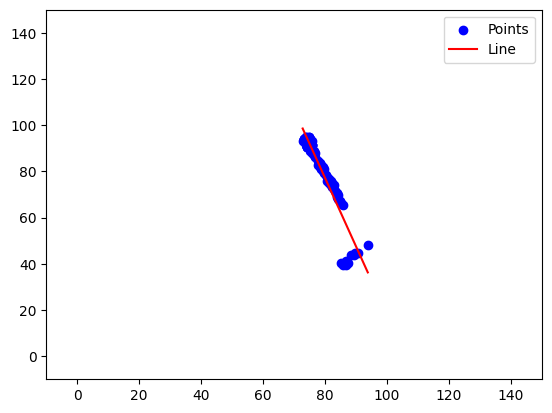

In [4]:
#1 line

points = singular_entry[['x', 'y']].to_numpy()




# Perform optimization
initial_guess = [0, 0]  # Initial guess for rho and theta
result = minimize(objective, initial_guess, args=(points,), method='BFGS')
rho, theta = result.x

print(f"rho: {rho}\ntheta: {theta}")

fig, ax = plt.subplots()

# Plot points
ax.scatter(points[:, 0], points[:, 1], color='blue', label='Points')
ax.set_xlim(-10, 150)
ax.set_ylim(-10, 150)


# Plot line(s)
x_vals = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
y_vals = (rho - x_vals * np.cos(theta)) / np.sin(theta)
ax.plot(x_vals, y_vals, color='red', label='Line')

ax.legend()
plt.show()


Line 1: y = -2.9655598436839106 * x + 314.3493815475177
Line 2: y = 1.083546521011807 * x + -53.557303563500255


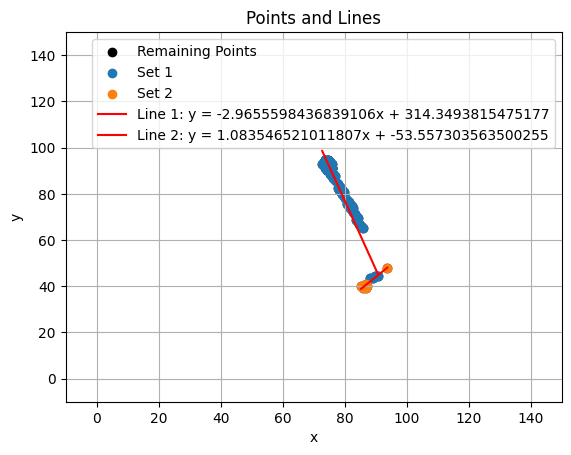

In [5]:
#more lines
nr_lines = 2000
distance_threshold = 3


plt.scatter(points[:, 0], points[:, 1], c='k', label='Remaining Points')

def detect_lines(points):
    lines = []
    set_points = []
    iter = 0
    while len(points) > 0 and iter < nr_lines:
        # Perform optimization
        initial_guess = [0, 0]  # Initial guess for rho and theta
        result = minimize(objective, initial_guess, args=(points,), method='BFGS')
        rho, theta = result.x

        # Calculate line equation
        m = -np.cos(theta) / np.sin(theta)  # Slope
        b = rho / np.sin(theta)             # Intercept
        line_equation = (m, b)
        lines.append(line_equation)

        # Remove points belonging to the detected line
        distances = [hessian_distance((rho, theta), point) for point in points]

        #the indices of the points to be removed
        points_to_remove = np.where(np.array(distances) <= distance_threshold)[0]

        #plt.scatter(points[points_to_remove, 0], points[points_to_remove, 1], label=f'Set {iter+1}')


        set_points.append(points[points_to_remove])
        points = np.delete(points, points_to_remove, axis=0)
        iter += 1

    #plt.scatter(points[:, 0], points[:, 1], c='k', label='Remaining Points')

    return lines, set_points

[line_equations, set_points] = detect_lines(points)

for i, equation in enumerate(line_equations):
    m, b = equation
    print(f"Line {i+1}: y = {m} * x + {b}")

#draw
for i, sets in enumerate(set_points):
    plt.scatter(sets[:, 0], sets[:, 1], label=f'Set {i+1}')




for i in range(len(line_equations)):
    m, b = line_equations[i]
    min_x = np.min(set_points[i][:, 0])
    max_x = np.max(set_points[i][:, 0])
    x = np.array([min_x, max_x])
    y = m * x + b
    plt.plot(x, y, c='r', label=f"Line {i+1}: y = {m}x + {b}")
    

#plt.plot(x, y, c='r', label=f"Line {i+1}: y = {m}x + {b}")
plt.xlim(-10, 150)
plt.ylim(-10, 150)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Points and Lines')
plt.grid(True)
plt.show()